# Exercise 02 - Simulation of the 2d-Ising-model
The two-dimensional Ising-model is studied via a Markov-Chain-Monte-Carlo-Simulation (MCMC) and the results will be compared to analytically calculated solutions.
## Theory
Similar to the one dimensional case, the hamiltonian for the two-dimensional spin-lattice $\mathbf{s}$ in an external magnetic field $h$ in a heat bath of temperature $T$ and with side lengths $N$ is given by 
$$\mathcal{H}(\mathbf{s})=-J\sum_{\langle x,y\rangle}s_xs_y-h\sum_{x}^Ns_x, $$ where $x$ now numbers the lattice site. $\langle x,y\rangle$ denotes the sum over the nearest neighbors, thus $J$ is the coupling strength between the spins. Periodic boundary conditions are assumed in each direction. The probability of finding a specific spin configuration $\mathbf{s}$ is given by 

$$\mathbf{P}(\mathbf{s})=\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s})}{k_bT}\bigg)}/\sum_{\mathbf{s'}}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}:=\frac{1}{Z}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}$$

with the partition function $Z:=\sum_{\mathbf{s'}}\exp{\left(\frac{-\mathcal{H}(\mathbf{s'})}{k_BT}\right)}$. In the thermodynamic limit ($N\to\infty$) solutions for energy per site $\epsilon$ and magnetization per spin $m$ with $h=0$ are known:

$$\epsilon=-J \text{coth}(2 J)\left(1+\frac{2}{\pi}\left(2 \tanh ^{2}(2 J)-1\right) K\left(4 \text{sech}^{2}(2 J) \tanh ^{2}(2 J)\right)\right)$$


$$|m|=\begin{cases}
    \left(1-\frac{1}{\sinh ^{4}(2.7)}\right)^{1 / 8} & \forall J>J_c \\
    0 & \forall J\leq J_c
    \end{cases}
$$
Where $J_c=\frac{1}{2}\log{(1+\sqrt{2})}$ and $K(m)$ is the incomplete elliptic integral of the first kind. 

*4. What is the significance of the critical coupling $J_c$ ?*

$J_c$ is the coupling strength belonging to the critical temperature $T_c$. Below the critical temperature it is $J>J_c$ therefore a net magnetization can be measured. For $J<J_c$ the coupling is not sufficient to reach a net magnetization, i.e. for temperatures larger than the critical temperature.

## Aim of the code

*1. Modify your 1D Ising code so that it works in 2 dimensions as described above. Furthermore, implement the Metropolis-Hastings accept/reject that was discussed in the lectures
(in other words do NOT do a “brute-force” calculation like in the previous homework). Set
your code up such that measurements are done after each “sweep” of the lattice, where a
“sweep” constitutes looping over all sites on the lattice, and at each site flipping its spin and
performing the Metropolis-Hastings accept/reject step. In other words, after each “sweep” of
the lattice you will have performed $\Lambda$ accept/reject tests .*

Below the implementation of the desired code can be found. We divided it into two parts, the numerical approach, where we use a Monte-Carlo-Simulation to get a result and the analytical approach where we simply implemented the analytically obtained results in python code.

### Numerical approach

To simulate the properties of the 2d Ising-model a Markov-Chain-Monte-Carlo Method is used. It employs the following algorithm
1. choose a random spin $s_{ij}$
2. flip the spin and determine the change in energy $\Delta S=\mathcal{H}(\mathbf{s}^{\text{flipped}})-\mathcal{H}(\mathbf{s}^\text{unflipped})$ (where $\beta=1$)
3. sample random $y$ $\sim \mathcal{U}(0,1)$
4. if $y\leq \exp(-\Delta S)$ ACCEPT the spin flip, otherwise REJECT
5. repeat 1.-4. $\Lambda=N^2$ times
6. make measurement $O_i$ and store it
7. go back to 1. $M$ times
8. calculate Monte Carlo estimate as $\langle O \rangle =1/M\sum_{i=1}^M O_i$

This algorithm makes sure that the distribution of the spins follows the Boltzmann-distribution while simultaneously only those parts of the partition sum which contribute significantly (small energys) are kept and considered in the calculation of expectation values such as magnetization and energy.

*How does the numerical cost of the calculation of the energy (for a given spin configuration) scale with the system size $\Lambda$?*
The numerical costs of the calculation of the energy scales linearly with $\Lambda=N^2$

*Assuming you’ve flipped one spin $s_i$, how does the numerical cost of the calculation of
the change in energy $\Delta S$ scale with the system size $\Lambda$?*
If we only flip one spin, then all of the interaction terms $\propto s_is_j$ with the respective next neighbors will cancel out excluding the term with flipped spin; this leads to 
$$\Delta S = \mathcal{H}(\mathbf{-s})-\mathcal{H}(\mathbf{s})=J s_i\sum_{\langle j \rangle} s_j+h\cdot s_i - h\cdot\sum_{j, j\neq i}s_j-\left(-Js_i\sum_{\langle j \rangle} s_j-hs_i-h\cdot\sum_{j, j\neq i}s_j\right)=2s_i\left(\sum_{\langle j \rangle} Js_j+h\right).$$
Therefore the numerical cost of calculating $\Delta S$ is independent of $\Lambda$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

N = 6
nTherm = 500
nMeas = 1000
lamda = N**2
T = 1
h = 1
J = 0.4
beta = 1/T

# A method to set the plot parameters and make them beautiful ;)
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def generate_spin_config(N):
    #spin_config = []
    #for i in range(N):
    #    spin_config.append(([(-1)**i for i in range(N)]))
    return 2*np.random.randint(2, size=(N,N))-1
    #print(spin_config)
    #return np.array(spin_config)


def neighbors(s,x,y):
    left = s[y][x-1]
    right = s[y][(x+1)%N]
    bottom = s[(y+1)%N][x]
    top = s[y-1][x]
    return left, right, bottom, top


def calc_delta_S(s,J,h,x,y,N):
    return 2 * s[y][x]*(J*(np.sum(neighbors(s,x,y))) + h)

def Hamiltonian(s,J, N):
    neighbor_sum = 0
    for i in range(N):
        for j in range(N):
            neighbor_sum += s[j][i]*(s[(j+1)%N][i]+s[j][(i+1)%N])
    return -J*neighbor_sum

def numerical(J, h, N):
    spin_conf = generate_spin_config(N)
    plot_x = []
    plot_y = []
    
    for i in range(nTherm):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        delta_S = calc_delta_S(spin_conf,J,h,x,y,N)
        rand = np.random.uniform(0,1)
        if rand <= np.exp(-beta*delta_S): # also accept
            spin_conf[y][x] *= -1
        plot_x.append(i)
        plot_y.append(np.mean(spin_conf))
    #plt.plot(plot_x,plot_y)
    #plt.show()
    
    m=np.array([])
    energy=np.array([])
    m_plot_y=np.array([])
    for i in range(nMeas):
        for j in range(lamda):
            x = np.random.randint(0,N)
            y = np.random.randint(0,N)
            delta_S = calc_delta_S(spin_conf,J,h,x,y,N)
            if np.random.uniform(0,1) <= np.exp(-beta*delta_S): # also accept
                spin_conf[y][x] *= -1
        m=np.append(m,spin_conf.mean())
        energy = np.append(energy, Hamiltonian(spin_conf,J,N))

    return np.mean(m), np.mean(np.abs(m)), np.mean(energy)



def epsilon(J):
    return -J*np.tanh(2*J)**(-1)*(1+2/np.pi*(2*np.tanh(2*J)**2-1)*sc.ellipk(4*np.cosh(2*J)**(-2)*np.tanh(2*J)**2))

J_c=1/2*np.log(1+np.sqrt(2))
def analytical_m(J):
    if J>J_c:
        return (1-1/(np.sinh(2*J)**4))**(1/8)
    else:
        return 0


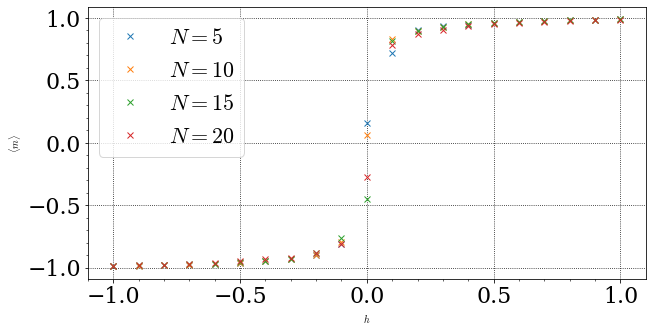

In [2]:
magnetization = []

m = []
h_list = [i for i in np.linspace(-1,1,21)]
N_list = [5, 10, 15, 20]

beauty_plot()
for N in N_list:
    for h in h_list:
        m.append(numerical(J, h, N)[0])
    plt.plot(h_list, m,"x", label="$N=%d$"%(N))
    m = []

plt.xlabel("$h$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()


### 6) Calculation of the energy $\varepsilon$

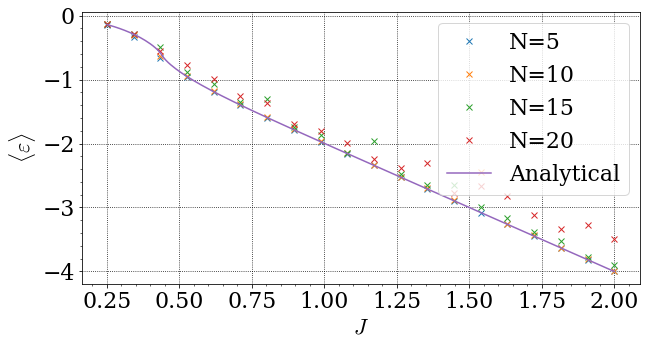

In [3]:
h=0
J_list = np.linspace(0.25, 2, 20)
J_list_analytical = np.linspace(0.25, 2, 200)
analytical_result = epsilon(J_list_analytical)
N_list = [5, 10, 15, 20]
beauty_plot()
for N in N_list:
    numerical_result = []
    for J in J_list:
        numerical_result.append(numerical(J, 0, N)[2])
    plt.plot(J_list, np.array(numerical_result)/N**2, "x", label="N=%d"%(N))

plt.plot(J_list_analytical, analytical_result, label="Analytical")
plt.xlabel("$J$")
plt.ylabel("$\\langle \\varepsilon \\rangle$")
plt.legend()
plt.show()

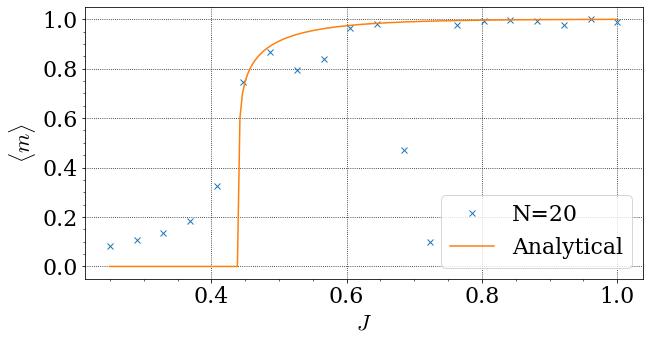

In [16]:
h=0
J_list = np.linspace(0.25, 1, 20)
J_list_analytical = np.linspace(0.25, 1, 200)
analytical_m_result = []
for J in J_list_analytical:
    analytical_m_result.append(analytical_m(J))
nTherm = 10000
nMeas = 5000
N_list = [20]# 5, 10, 15, 20]
beauty_plot()
for N in N_list:
    numerical_result = []
    for J in J_list:
        numerical_result.append(numerical(J, 0, N)[1])
    plt.plot(J_list, np.array(numerical_result), "x", label="N=%d"%(N))

plt.plot(J_list_analytical, analytical_m_result, label="Analytical")
plt.xlabel("$J$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()

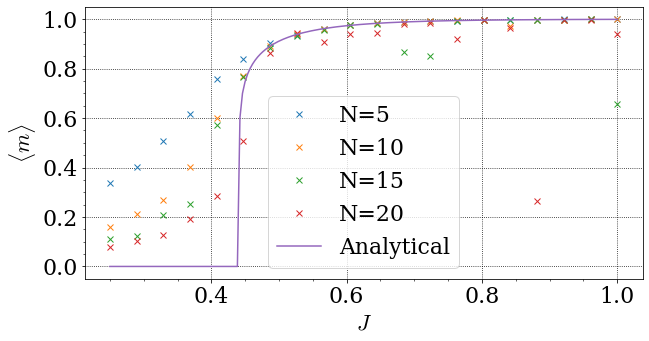

In [20]:
h=0
J_list = np.linspace(0.25, 1, 20)
J_list_analytical = np.linspace(0.25, 1, 200)
analytical_m_result = []
for J in J_list_analytical:
    analytical_m_result.append(analytical_m(J))
nTherm = 10000
nMeas = 5000
N_list = [5, 10, 15, 20]
beauty_plot()
for N in N_list:
    numerical_result = []
    for J in J_list:
        numerical_result.append(numerical(J, 0, N)[1])
    plt.plot(J_list, np.array(numerical_result), "x", label="N=%d"%(N))

plt.plot(J_list_analytical, analytical_m_result, label="Analytical")
plt.xlabel("$J$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()